# 拉勾-数据分析岗位分析
作者：lzyu86（紫雨）

# 目录
1. 提出问题
2. 理解数据
 * 采集数据
 * 导入数据
 * 查看数据集信息
3. 数据清洗
 * 数据预处理
 * 特征值提取
4. 数据可视化
 * 城市岗位分布
 * 行业分布
 * 工作经验需求分布
 * 薪资水平分布
 * 公司融资情况分布
 * 职业技能需求
 * 城市-薪资关系
 * 行业-薪资关系
 * 经验-薪资关系
 * 融资阶段-薪资关系
5. 结论

# 1.提出问题
* 数据分析的岗位主要在哪些城市分布 
* 数据分析的岗位在哪些行业中需求较大
* 数据分析的岗位对工作经验的要求
* 数据分析的岗位薪资水平如何
* 数据分析的岗位在何种融资阶段的公司需求较大
* 数据分析的岗位主要要求哪些职业技能
* 数据分析的岗位中以上何种因素对薪资水平影响较大

# 2.理解数据
## 理解数据分为三部分：

1）采集数据：根据提出的若干问题，自己编写爬虫，采集拉勾网-数据分析岗位的相关数据

2）导入数据：将爬取的数据导入到Python中的数据结构中

3）查看数据集信息

### 2.1 采集数据

[拉勾数据爬取](https://github.com/lzyu86/creator/blob/master/lagou.csv)

### 2.2 导入数据

In [1]:
#引入模块
import pandas as pd
import matplotlib.pyplot as plt
import jieba.analyse    #提取关键词
from wordcloud import WordCloud    
import numpy as np
#from PIL import Image  也是wordcloud中添加读取mask图片的一种方式
import imageio   #读取mask图片的方式更简洁

In [2]:
#读取爬虫文件
file='./lagou.csv'    #文件路径
positionDf = pd.read_csv(file)     #读取文件

### 2.3查看数据集信息

In [3]:
positionDf.head()   #显示前5行，了解数据信息

,公司,职位,城市,行业,职业技能,工作年限,薪资,融资情况
0,盈富斯,企划专员,广州,电商,"['市场分析', '市场竞争分析', '数据分析']",不限,4k-6k,C轮
1,汇付,数据分析,上海,"移动互联网,金融","['SQL', '数据分析']",3-5年,10k-20k,上市公司
2,毒APP,数据分析师,上海,"移动互联网,电商","['Hadoop', 'MySQL', '数据挖掘']",不限,20k-30k,B轮
3,网达软件,数据分析,上海,"移动互联网,电商","['SQL', 'SPSS', '数据分析', '数据库']",1-3年,6k-7k,上市公司
4,拉勾网,数据分析师,北京,企业服务,"['SQL', '数据分析', 'BI', 'SPSS']",1-3年,10k-18k,D轮及以上


In [4]:
#对数据列名重命名
rename = {'公司':'company','职位':'position','城市':'city','行业':'industryfield','职业技能':'skill','工作年限':'time','薪资':'income','融资情况':'finance_stage'}
positionDf.rename(columns = rename,inplace=True)
positionDf.head()  #确认更改后效果

,company,position,city,industryfield,skill,time,income,finance_stage
0,盈富斯,企划专员,广州,电商,"['市场分析', '市场竞争分析', '数据分析']",不限,4k-6k,C轮
1,汇付,数据分析,上海,"移动互联网,金融","['SQL', '数据分析']",3-5年,10k-20k,上市公司
2,毒APP,数据分析师,上海,"移动互联网,电商","['Hadoop', 'MySQL', '数据挖掘']",不限,20k-30k,B轮
3,网达软件,数据分析,上海,"移动互联网,电商","['SQL', 'SPSS', '数据分析', '数据库']",1-3年,6k-7k,上市公司
4,拉勾网,数据分析师,北京,企业服务,"['SQL', '数据分析', 'BI', 'SPSS']",1-3年,10k-18k,D轮及以上


In [5]:
#确认数据类型，确认数据有无缺失
positionDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 8 columns):
company          450 non-null object
position         450 non-null object
city             450 non-null object
industryfield    450 non-null object
skill            450 non-null object
time             450 non-null object
income           450 non-null object
finance_stage    450 non-null object
dtypes: object(8)
memory usage: 28.2+ KB


根据上述数据信息显示，共计8列，450行数据，并且每行数据无缺失，不需要特别对数据进行缺失补充（数据爬取还是蛮成功的O(∩_∩)O），后面的数据清洗会变得轻松些许，可以跳过数据预处理，小跳一下，进入特征值提取。

## 3.数据清洗 

## 3.1 数据预处理 

这里我就无耻的跳过了，毕竟爬取的数据还是很好的！！！

### 3.2 特征值提取 

#### 3.2.1 行业信息提取

从数据信息中可以看出，行业描述数量不等，且有的显示“移动互联网”行业，不具有明显特征，区分度不高。这里对于有两个描述的，我直接选择第二个行业描述，对于只有一中描述的，我用“电商”直接代替。

In [6]:
#定义提取行业关键字函数
def get_key(industryfield):
    try:
        a = industryfield.split(',')[1]    #根据行业信息显示，对多种行业类别的先通过‘,’分割数据
        b = a.split('丨')[0].split(' ')[0]   #对含有‘丨’的数据分割，最后对存在空格分隔的数据进行分割
    except:
        b = industryfield.split('丨')[0].split(' ')[0]    #对一种行业类别的，仅含有丨’的数据分割
    if b == '移动互联网':
        b = '电商'
    return b

In [7]:
#获取清洗后的行业数据
industry = pd.DataFrame()
industry['field'] = positionDf['industryfield'].map(get_key)
industry.head()

,field
0,电商
1,金融
2,电商
3,电商
4,企业服务


In [8]:
#将清洗后的行业数据和原数据合并，并将原行业数据删除
a = positionDf     #复制原数据
a = pd.concat([positionDf,industry],axis=1)     #合并数据
a.drop('industryfield',axis=1,inplace=True)     #删除数据
a.head()

,company,position,city,skill,time,income,finance_stage,field
0,盈富斯,企划专员,广州,"['市场分析', '市场竞争分析', '数据分析']",不限,4k-6k,C轮,电商
1,汇付,数据分析,上海,"['SQL', '数据分析']",3-5年,10k-20k,上市公司,金融
2,毒APP,数据分析师,上海,"['Hadoop', 'MySQL', '数据挖掘']",不限,20k-30k,B轮,电商
3,网达软件,数据分析,上海,"['SQL', 'SPSS', '数据分析', '数据库']",1-3年,6k-7k,上市公司,电商
4,拉勾网,数据分析师,北京,"['SQL', '数据分析', 'BI', 'SPSS']",1-3年,10k-18k,D轮及以上,企业服务


#### 3.2.2 薪资信息提取

在每家公司的薪资信息中，使用薪资区间表示。我在这里提取区间的平均值来表示每家公司的薪资水平。

In [9]:
#定义获取薪资函数
def get_income(income):
    try:
        income_min = int(income.split('-')[0].split('k')[0])    
        income_max = int(income.split('-')[1].split('k')[0])
        income_avg = round( (income_min+income_max)/2)
    except:
        income_avg = round(income.split('k'))
    return income_avg

In [10]:
#获取清洗后的薪资数据
incomeDf = pd.DataFrame()
incomeDf['salary'] = positionDf['income'].map(get_income)
incomeDf.head()

,salary
0,5
1,15
2,25
3,6
4,14


In [11]:
#将清洗后的薪资数据合并至已更新行业数据的总表
b = a
b = pd.concat([a,incomeDf],axis=1)
b.drop('income',axis=1,inplace=True)
b.head()

,company,position,city,skill,time,finance_stage,field,salary
0,盈富斯,企划专员,广州,"['市场分析', '市场竞争分析', '数据分析']",不限,C轮,电商,5
1,汇付,数据分析,上海,"['SQL', '数据分析']",3-5年,上市公司,金融,15
2,毒APP,数据分析师,上海,"['Hadoop', 'MySQL', '数据挖掘']",不限,B轮,电商,25
3,网达软件,数据分析,上海,"['SQL', 'SPSS', '数据分析', '数据库']",1-3年,上市公司,电商,6
4,拉勾网,数据分析师,北京,"['SQL', '数据分析', 'BI', 'SPSS']",1-3年,D轮及以上,企业服务,14


#### 3.2.3 工作年限信息提取 

工作年限中，存在“不限”以及“应届毕业生”有别于其他几种的表现形式，这里我把“不限”和“应届毕业生”作为同种类型，整合到一起，并将它们均命名为“1年以下”，使形式上与其他几种类型保持一致

In [12]:
#定义获取工作年限的函数
def get_time(time):
    if time == '不限' or time == '应届毕业生' :    #不限和应届毕业生认为是同种类别，均定义为1年以下
            time = '1年以下'
    return time

In [13]:
#获取清洗后的经验数据
experience = pd.DataFrame()
experience['experience'] = b['time'].map(get_time)
experience.head()

,experience
0,1年以下
1,3-5年
2,1年以下
3,1-3年
4,1-3年


In [14]:
#将清洗后的数据合并至数据已更新（行业、薪资）数据总表
c = b
c = pd.concat([b,experience],axis=1)
c.drop('time',axis=1,inplace=True)
c.head()

,company,position,city,skill,finance_stage,field,salary,experience
0,盈富斯,企划专员,广州,"['市场分析', '市场竞争分析', '数据分析']",C轮,电商,5,1年以下
1,汇付,数据分析,上海,"['SQL', '数据分析']",上市公司,金融,15,3-5年
2,毒APP,数据分析师,上海,"['Hadoop', 'MySQL', '数据挖掘']",B轮,电商,25,1年以下
3,网达软件,数据分析,上海,"['SQL', 'SPSS', '数据分析', '数据库']",上市公司,电商,6,1-3年
4,拉勾网,数据分析师,北京,"['SQL', '数据分析', 'BI', 'SPSS']",D轮及以上,企业服务,14,1-3年


#### 3.2.4 职业技能信息提取

职业技能信息中类似列表形式，实则为字符串格式。为方便对其中的中英文描述进行快速提取，选择导入模块jieba进行分词，获取所需信息。

In [15]:
#载入个人词汇，保证jieba能按照用户要求进行分词
jieba.load_userdict('./skill.txt') 

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LZYU\AppData\Local\Temp\jieba.cache
Loading model cost 2.238 seconds.
Prefix dict has been built succesfully.


In [16]:
#定义获取职业技能函数
def get_skill(skill):   
    key_skill = jieba.analyse.extract_tags(skill,topK=20)      #提取关键词，输出为列表形式
    return key_skill

In [17]:
#获取清洗后的职业技能数据
skillDf = pd.DataFrame()
skillDf['key_skill'] = c['skill'].map(get_skill)
skillDf.head()

,key_skill
0,"[市场分析, 市场竞争分析, 数据分析]"
1,"[SQL, 数据分析]"
2,"[数据挖掘, Hadoop, MySQL]"
3,"[SQL, SPSS, 数据分析, 数据库]"
4,"[SQL, BI, SPSS, 数据分析]"


In [18]:
'''
测试清洗后的数据
skill_list = []
for i in range(len(skillDf['key_skill'])):
    for j in range(len(skillDf.loc[i,'key_skill'])):
        skill_list.append(skillDf.loc[i,'key_skill'][j])       
skill_list1 = pd.DataFrame(skill_list)
skill_list1.columns = ['skill']
'''

"\n测试清洗后的数据\nskill_list = []\nfor i in range(len(skillDf['key_skill'])):\n    for j in range(len(skillDf.loc[i,'key_skill'])):\n        skill_list.append(skillDf.loc[i,'key_skill'][j])       \nskill_list1 = pd.DataFrame(skill_list)\nskill_list1.columns = ['skill']\n"

In [19]:
#将清洗后的职业技能数据合并至已更新（行业、薪资、经验）数据总表
d=c
d = pd.concat([c,skillDf],axis=1)
d.drop('skill',axis=1,inplace=True)
d.head()

,company,position,city,finance_stage,field,salary,experience,key_skill
0,盈富斯,企划专员,广州,C轮,电商,5,1年以下,"[市场分析, 市场竞争分析, 数据分析]"
1,汇付,数据分析,上海,上市公司,金融,15,3-5年,"[SQL, 数据分析]"
2,毒APP,数据分析师,上海,B轮,电商,25,1年以下,"[数据挖掘, Hadoop, MySQL]"
3,网达软件,数据分析,上海,上市公司,电商,6,1-3年,"[SQL, SPSS, 数据分析, 数据库]"
4,拉勾网,数据分析师,北京,D轮及以上,企业服务,14,1-3年,"[SQL, BI, SPSS, 数据分析]"


## 4.数据可视化 

定义分组函数，对各列的特征进行对比分析

In [20]:
#定义分组函数，以column列为依据对Df数据进行分组
def get_group(Df,column):
    grouped = Df.groupby(column).size().sort_values(ascending = False)    #以column列为依据分组并计数，降序排列
    grouped_Df = pd.DataFrame(grouped)                                           #转为dataframe格式
    grouped_Df[column] = grouped_Df.index                                       #新建一列，数据为索引下的数据
    grouped_Df.columns = ['num',column]                                          #列重命名
    return grouped_Df

### 4.1城市岗位分布

In [21]:
#城市岗位分布
group_city = get_group(d,'city')

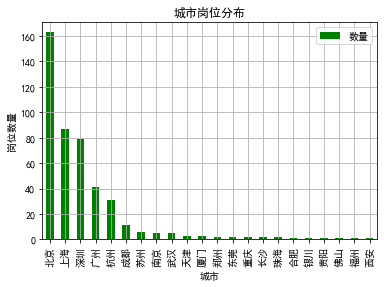

In [22]:
#绘制城市岗位分布图
group_city.plot.bar(x='city',y='num',label = '数量',color = 'g')   #绘图
plt.grid(True)                 #增加网格   
plt.xlabel('城市')             #行标签
plt.ylabel('岗位数量')      #列标签
plt.title('城市岗位分布')  #图片标题
plt.show()                   #显示图形

从上图可以看出，数据分析岗位较多的城市主要集中在：北京、上海、深圳、广州、杭州、成都，岗位数量依次递减，一线城市的需求数量最大，准一线城市紧随其后。

### 4.2 行业分布

In [23]:
#行业分布
group_field = get_group(d,'field')

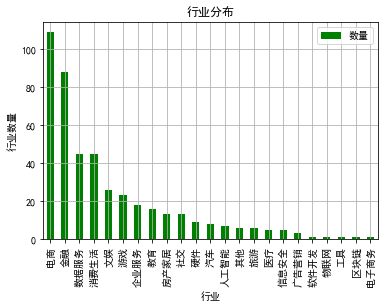

In [24]:
#绘制行业分布图
group_field.plot.bar(x='field',y='num',label = '数量',color = 'g')
plt.grid(True)                 #增加网格
plt.xlabel('行业')            #行标签
plt.ylabel('行业数量')     #列标签
plt.title('行业分布')       #图片标题
plt.show()                  #显示图形

从上图可以看出，占据绝对优势的行业为电商和金融，数据服务和消费生活类的行业次之。

### 4.3 工作经验需求分布 

In [25]:
#工作经验分布
group_experience = get_group(d,'experience')

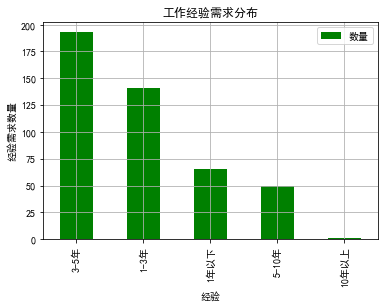

In [26]:
#获取工作经验分布图
group_experience.plot.bar(x='experience',y='num',label = '数量',color = 'g')
plt.xlabel('经验')
plt.grid(True)
plt.ylabel('经验需求数量')
plt.title('工作经验需求分布')
plt.show()

公司对3-5年经验的数据分析需求量最大，相对的，对10年以上经验的需求相对来说少之又少，推测可能是3-5年的分析师对行业发展已经有了比较成熟的认知，完成足够胜任公司的分析需求，而10年以上的数据分析岗位人员可能已经对市场动向了如指掌，转为产品经理，故需求量上会少很多。

### 4.4 薪资水平分布 

In [27]:
#总体薪资分布
group_salary = get_group(d,'salary')

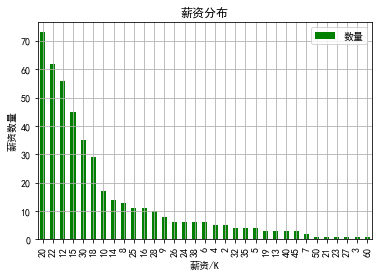

In [28]:
#绘制薪酬分布图
group_salary.plot.bar(x='salary',y='num',label = '数量',color = 'g')
plt.xlabel('薪资/K')
plt.grid(True)
plt.ylabel('薪资数量')
plt.title('薪资分布')
plt.show()

从薪资水平上来看，数据分析的岗位所提供的薪资待遇还算是比较令人满意的

### 4.5 公司融资情况分布

In [29]:
#融资阶段
group_finance_stage = get_group(d,'finance_stage')

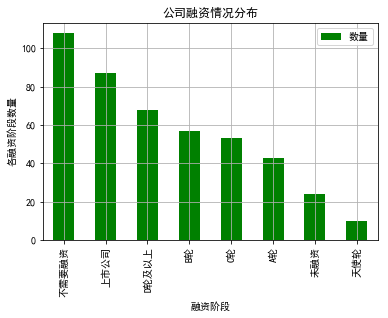

In [30]:
#绘制公司融资情况分布图
group_finance_stage.plot.bar(x='finance_stage',y='num',label = '数量',color = 'g')
plt.xlabel('融资阶段')
plt.grid(True)
plt.ylabel('各融资阶段数量')
plt.title('公司融资情况分布')
plt.show()

从上图可以看出，初步发展的公司（天使轮）对数据分析的岗位需求量比较小，反之，发展成熟的公司对此岗位的需求量则很大。

### 4.6 职业技能需求

In [31]:
#定义获取职业技能文件函数
def skill_list(key_skill):
    f = open('key_skill.txt','a')
    for i in key_skill:
        f.writelines(i+u',')
    f.close()

In [32]:
d['key_skill'].map(skill_list)
open_f = open('key_skill.txt','r').read() 

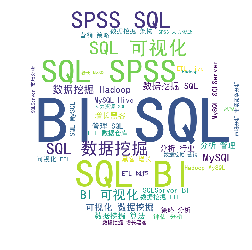

In [33]:
#img = np.array(Image.open('tree.jpg')) ，搭配from PIL import Image、import numpy as np使用
img = imageio.imread('tree.jpg')         #读取图片
#绘制云图
my_wordcloud = WordCloud(
            background_color='white',    # 设置背景颜色
            max_words = 200,            # 设置最大现实的字数
            mask = img,                 #设置背景图片
            font_path = 'SimHei.ttf',  #设置字体路径，保证中文可以显示
            stopwords = ['数据分析','数据库','数据','运营','商业','数据处理','风险'],      #剔除不需要显示的信息
            max_font_size = 80,            # 设置字体最大值
            random_state = 60,            # 设置有多少种随机生成状态，即有多少种配色方案
            scale=5
                ).generate(open_f)
plt.imshow(my_wordcloud)
plt.axis("off")
plt.show()

从云图中可以看出，具备BI、SQL技能的话，对于求职数据分析岗位会有很大帮助，如果会使用SPSS，想必会锦上添花。

通过定义薪资关系函数，获取薪资和其他列的函数关系数据

In [34]:
#定义薪资关系函数
def relation_salary(Df,cloumn,group):
    relation_a =  Df.groupby(cloumn)['salary']
    relation_list = []
    for i in group.index:
        relation_b = relation_a.get_group(i).values
        relation_list.append(relation_b)
    relationDf = pd.DataFrame( relation_list)
    relationDf = pd.DataFrame(relationDf.values.T, index=relationDf.columns, columns=relationDf.index)
    relationDf.columns = group.index
    return relationDf

### 4.7 城市-薪资关系 

In [35]:
#城市-薪资
city_salary = relation_salary(d,'city',group_city)

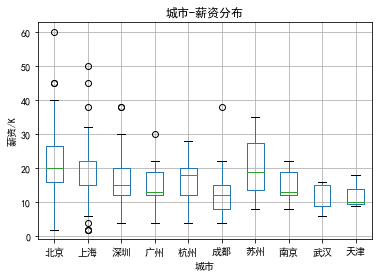

In [36]:
#绘制城市-薪资箱形图
city_salary.iloc[:,0:10].boxplot()    #城市偏多，仅取岗位最多的前10个城市数据绘制，靠后的城市薪酬数据偏少
plt.xlabel('城市')
plt.grid(True)
plt.ylabel('薪资/K')
plt.title('城市-薪资分布')
plt.show()

对比以上10座城市，一线城市中，上海对数据分析的岗位给出的薪资最高，北京次之；准一线城市中，苏州最大，杭州次之。但于我个人而言，就上图的薪资水平，从生活品质上来说，地上的天堂（苏杭），相对于上海、北京，更具有诱惑力。

### 4.8 行业-薪资关系  

In [37]:
#行业-薪资
field_salary = relation_salary(d,'field',group_field)

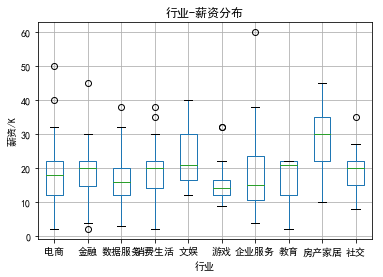

In [38]:
#绘制行业-薪资箱形图
field_salary.iloc[:,0:10].boxplot()
plt.xlabel('行业')
plt.grid(True)
plt.ylabel('薪资/K')
plt.title('行业-薪资分布')
plt.show()

从行业-薪资关系来看，虽然电商和金融在数据分析岗位中占比最大，但薪资处于第二梯队，薪资待遇算不上最好的。最好的要属行业分布中处于第三梯度的文娱以及房产家居。

### 4.9 经验-薪资关系 

In [39]:
#经验-薪资
experience_salary = relation_salary(d,'experience',group_experience)
#变换列的顺序
order = ['1年以下','1-3年','3-5年','5-10年','10年以上']
experience_salary = experience_salary[order]

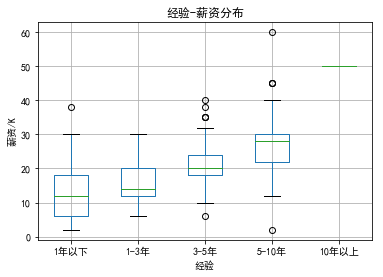

In [40]:
#绘制经验-薪资箱形图
experience_salary.boxplot()
plt.xlabel('经验')
plt.grid(True)
plt.ylabel('薪资/K')
plt.title('经验-薪资分布')
plt.show()

从上图可以发现比较符合常理的事情，就是随着经验的提升，个人所能够获得的薪资也会相应提高。

In [41]:
'''
定义函数前的原始code
#经验-薪酬
experience_salary = d.groupby('experience')['salary']

experience_salary_list=[]
for i in grouped_experience.index:
    a = experience_salary.get_group(i).values
    experience_salary_list.append(a)
experience_salary_Df = pd.DataFrame(experience_salary_list)  
#experience_salary_Df

experience_salary_Df1 = pd.DataFrame(experience_salary_Df.values.T, index=experience_salary_Df.columns, columns=experience_salary_Df.index)
experience_salary_Df1.columns = grouped_experience.index
#experience_salary_Df1

#变换列的顺序
order = ['1年以下','1-3年','3-5年','5-10年','10年以上']
experience_salary_Df1 = experience_salary_Df1[order]
#experience_salary_Df1

experience_salary_Df1.boxplot()
plt.grid(True)
plt.xlabel('经验')
#y坐标轴文本
plt.ylabel('薪酬')
#图片标题
plt.title('经验-薪酬分布')
plt.show()
'''

"\n定义函数前的原始code\n#经验-薪酬\nexperience_salary = d.groupby('experience')['salary']\n\nexperience_salary_list=[]\nfor i in grouped_experience.index:\n    a = experience_salary.get_group(i).values\n    experience_salary_list.append(a)\nexperience_salary_Df = pd.DataFrame(experience_salary_list)  \n#experience_salary_Df\n\nexperience_salary_Df1 = pd.DataFrame(experience_salary_Df.values.T, index=experience_salary_Df.columns, columns=experience_salary_Df.index)\nexperience_salary_Df1.columns = grouped_experience.index\n#experience_salary_Df1\n\n#变换列的顺序\norder = ['1年以下','1-3年','3-5年','5-10年','10年以上']\nexperience_salary_Df1 = experience_salary_Df1[order]\n#experience_salary_Df1\n\nexperience_salary_Df1.boxplot()\nplt.grid(True)\nplt.xlabel('经验')\n#y坐标轴文本\nplt.ylabel('薪酬')\n#图片标题\nplt.title('经验-薪酬分布')\nplt.show()\n"

### 4.10 融资阶段-薪资关系  

In [42]:
#融资阶段-薪资
finance_stage_salary = relation_salary(d,'finance_stage',group_finance_stage)
#变换列的顺序
order1 = ['不需要融资','未融资','天使轮','A轮','B轮','C轮','D轮及以上','上市公司']
finance_stage_salary = finance_stage_salary[order1]

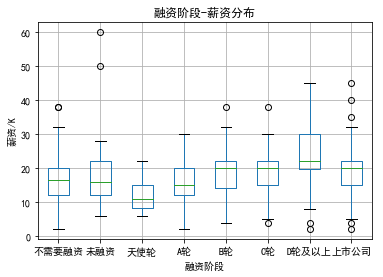

In [43]:
#绘制融资阶段-薪资箱形图
finance_stage_salary.boxplot()
plt.xlabel('融资阶段')
plt.grid(True)
plt.ylabel('薪资/K')
plt.title('融资阶段-薪资分布')
plt.show()

在爬取的招聘公司中，融资情况为D轮及以上的公司需求人员多，且提供薪资福利也最高，如果投递简历的话，选择D轮及以上的公司为最佳选择。

## 结论 

* 本次主要对城市岗位、行业、工作经验、薪资水平、公司融资情况以及职业技能进行了单独分析，可以了解到，数据分析岗位在一线城市发展成熟的公司需求量最大，准一线城市次之，主要集中在电商和金融行业，且公司都比较倾向于具有3-5年工作经验的分析师，且需要具备SQL、BI、SPSS等技能。
* 随后还对影响薪资水平的若干因素（城市、行业、工作经验、融资阶段）进行了分析。可以发现，在城市方面，一线城市中，上海对数据分析的岗位给出的薪资最高，北京次之；准一线城市中，苏州最大，杭州次之；行业方面，虽然电商和金融在数据分析岗位中占比最大，但薪资处于第二梯队，薪资待遇算不上最好的。最好的要属行业分布中处于第三梯度的文娱以及房产家居；经验方面，随着经验的提升，个人所能够获得的薪资也会相应提高融资阶段方面；融资情况为D轮及以上的公司需求人员多，且提供薪资福利也最高，如果投递简历的话，选择D轮及以上的公司为最佳选择。
* 综上所述，虽然准一线岗位需求量较少，但薪资水平还是比较高的，尤其是在环境比较好的苏杭，如果个人偏好于文娱、游戏方面，并有幸进入一家D轮及以上的相关公司，能够投身其中，长期积攒经验，那将是非常不错的选择！